# BDP Final Assignment Twitter Education, Part 3a: Measuring Influence

Recall

In [1]:
#Ensure we are using the right kernel
spark.version

'3.1.3'

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

#from itertools import compress 
import seaborn as sns 
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings(action='ignore')
#warnings.simplefilter('ignore')

In [3]:
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession

GCP Tools and Functions

In [4]:
from google.cloud import storage

In [5]:
# Reading data from open bucket
# Located at my BDP-bucket

dataPath = 'gs://msca-bdp-students-bucket/shared_data/hjiang248/final_sdf_v9_formatted_2'

In [6]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

# Read data

In [7]:
%%time

education_DF = spark.read.parquet(dataPath)

CPU times: user 3.79 ms, sys: 5.13 ms, total: 8.93 ms
Wall time: 6.43 s


In [8]:
# select the dataset
data = education_DF #.select([
#                            x for x in education_DF.columns 
#                            if ('qt' not in x) and (x not in ['quoted_status'])
#                           ])

# rename columns
data = data.withColumnRenamed('rtstatus_favorite_count', 'rt_favorite_count')\
           .withColumnRenamed('rtstatus_retweet_count', 'retweet_count')\
           .withColumnRenamed('rtstatus_quote_count', 'quote_count')\
           .withColumnRenamed('source_rt_usr_id', 'rt_user_id')\
           .withColumnRenamed('source_rt_id', 'rt_id')


# cast dataType
data = data.withColumn('favorite_count', data['favorite_count'].cast(IntegerType())) \
           .withColumn('retweet_count', data['retweet_count'].cast(IntegerType())) \
           .withColumn('quote_count', data['quote_count'].cast(IntegerType()))

data = data.withColumn('favorite_count', data['favorite_count'].cast(IntegerType())) \
           .withColumn('followers_count', data['followers_count'].cast(IntegerType()))

In [9]:
#data.select('verified_user').groupBy('verified_user').count()

In [10]:
edu_influence = data.select(['date','user_id', 'id', 'retweeted', 'retweet_count', 
                             'quote_count', 'followers_count', 'favorite_count', 'rt_user_id'])

edu_influence.printSchema()

root
 |-- date: date (nullable = true)
 |-- user_id: long (nullable = true)
 |-- id: long (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- favorite_count: integer (nullable = true)
 |-- rt_user_id: long (nullable = true)



In [11]:
edu_influence.count()

6235280

# Influence Score, how do we design the rules of calculation?
In this section, we firstly focuse on counting the number of original tweets and retweets by user.

Then, the question is: how to measure influence? There's a lot of discussion. Some uses participation rate (total tweet / total engagement), while some might consider pageRank.Practically, we can roughly divide it by two tasks: (1) collect all data, and (2) calculate influence score.

In the first step, we need to collect enough information. It includes:
- user_id
- user_name
- organization
- follower number
- total tweets (original and retweet)

Next, we need to calculate the influence score. Two methods are considerated: (1) engagement method, and (2) pageRank method.

Engagement Method:
- This method calculates the `Influence Coefficient (alpha)` with engagement (retweet, quote, & favorite) per tweet. The influence score is calculated by `alpha`, `total tweets` and `follower`
- Influence Coefficient = $\alpha$*
$$\alpha = \frac{Retweet + Quote}{Favorites+Retweet+Quote}$$

$$ Influence\,Score = \bar{\alpha} \cdot (1  \cdot Total\,Retweet + 2  \cdot Total\,Original)\cdot99\% + Followers\cdot1\%$$

Notes:
\*
- For each twitter, we take the average of influence coefficient among all tweets
- `Total Retweeted` means how much one user is being retweeted, while `Total Retweet` means how much one user retweets others. We use the later to calculate one's influence per tweet and the former to calculate one's overall influence
- Quote is rewarded with weight of `2.0` because it takes more actions and time than quote, which is considered as a result from stronger influenced move

PageRank Method:
- This method calculates the `Influence Score` with follower and total participation (retweet, quote, & favorite). 
- The influence score is calculated as:
$$ Influence\,Score = \frac{Sum\,Retweets + Sum\,Quotes + Sum\,Favorite}{Total\,Tweets(=Retweeted + Original)}*0.99 + follower*0.01$$

Given the data structure and how Twitter API records data, the first method is more reasonable. Consider the following case: User A retweeted an oringinal tweet by User C at 05/01/2022, and so A's retweet records C's tweet's `retweet_count` and `quote_count`. The next day, User B retweeted the same tweet of C, which also recorded the `retweet_count` and `quote_count`. 

Here we see a risk of using duplicated data if we groupby `source user id`(which is C's id) and `sum(retweet_count+quote_count)` . However, if we use method 1, we will groupby `source user id`(which is C's id) and `count(*)` which is the number of times C have been retweeted. By comparision, we find that method\#1 makes more sense for calculation.



Reference:
- https://github.com/dataabc/weiboPR

## Dataframe Build

In [12]:
edu_influence = edu_influence.withColumn('retweeted', F.when(edu_influence.retweeted == 'RT', edu_influence.retweeted)\
                                                       .when(((edu_influence.retweeted.isNotNull()) & (edu_influence.retweeted != 'RT')), 'original') \
                                                       .otherwise('unknown')
                                        )

### 1. total retweet

Total Tweet (total original and retweet per user, **which is different from how much a user is retweeted**

In [13]:
# seperate a new dataframe so that the .drop() won't affect source dataframe
tweet_count_rt = edu_influence.filter(edu_influence.retweeted == 'RT')
tweet_count_rt = tweet_count_rt.drop('user_id').withColumnRenamed('rt_user_id', 'user_id')

tweet_count_rt = edu_influence.select(['user_id', 'id', 'retweeted']) \
                              .groupBy(['user_id']).agg(count('*').alias('total_retweet'))

#tweet_count_rt.limit(10)

### 2: total original tweet

In [14]:
tweet_count_original = edu_influence.filter(edu_influence.retweeted == 'original') \
                            .select(['user_id', 'id', 'retweeted']) \
                            .groupBy(['user_id']).agg(count('*').alias('total_original'))

#tweet_count_original.limit(10)

### 3: total retweet (total number of retweets, quotes)

Retweet (aka. retweet count, meaning how often a user is retweeted)

```
# 12-06 新算法

# seperate a new dataframe so that the .drop() won't affect source dataframe
retweet_count_rt = edu_influence.filter(edu_influence.retweeted == 'RT')
retweet_count_rt = retweet_count_rt.drop('user_id').withColumnRenamed('rt_user_id', 'user_id')

# count total retweet per user
retweet_count_rt = retweet_count_rt.select(['user_id', 'retweet_count', 'quote_count']) \
                                .groupBy(['user_id'])\
                                .agg(sum('retweet_count').alias('retweeted'), sum('quote_count').alias('quoted'))

retweet_count_rt = retweet_count_rt.withColumn('total_retweeted', (col('retweeted') + col('quoted')))\
                                   .drop('retweeted', 'quoted')
```

In [15]:
# 12-06 新算法

# seperate a new dataframe so that the .drop() won't affect source dataframe
retweet_count_rt = edu_influence.filter(edu_influence.retweeted == 'RT')
retweet_count_rt = retweet_count_rt.drop('user_id').withColumnRenamed('rt_user_id', 'user_id')

# count total retweet per user
retweet_count_rt = retweet_count_rt.select(['user_id', 'retweeted']) \
                                .groupBy(['user_id'])\
                                .agg(count('*').alias('total_retweeted'))

In [16]:
#retweet_count_rt.limit(10)

---

### 4. Match names

In [17]:
# create a dataframe so that we can match the user ids to user names
user_profile = data.select(['date','user_id', 'user_name','organization', 'verified_user', 'country', 'followers_count']).orderBy('date', ascending=False)

# Drop duplicate and keep the latest user name
user_profile = user_profile.dropDuplicates(['user_id']).drop('date')

In [18]:
#user_profile.filter(user_profile.followers_count.isNull()).limit(5)
user_profile.limit(5)

user_id,user_name,organization,verified_user,country,followers_count
509,Time for good tro...,Other,false,null,8731
1999,Bjornfire 🌻,Other,false,null,2302
6463,wyclif ⚓,Other,false,null,3092
7106,Michael David Guzman,Other,false,null,185
7126,WnDowFunc,Other,false,null,204


### 5. Influence Coefficient: measuring the impact per tweet

In [19]:
influence_DF = edu_influence.na.fill(value=0, subset=['retweet_count', 'quote_count', ])

influence_DF = edu_influence.withColumn('influence_coef', 
                                        ((col('retweet_count') + col('quote_count'))*1.0 / (1 + col('retweet_count') + col('quote_count') + col('favorite_count')))
                                       )

In [20]:
# calculate avergae influence coeffcient
influence_DF_2 = influence_DF.groupby('rt_user_id').agg(mean('influence_coef').alias('avg_influence_coef'))

# change col name for easier join operation

influence_DF_2 = influence_DF_2.withColumnRenamed('rt_user_id', 'user_id')

In [21]:
#influence_DF_2.limit(5)

### Joining results

Now, we have the avg influence coefficient for each twitter. The next step is to join this avg_influence_coef to the count of their original tweet and retweets.

In [22]:
# join the results (counts of original tweets & avg influence coefficient)
influence_DF_original = influence_DF_2.join(tweet_count_original, on='user_id', how='left')

In [23]:
#influence_DF_original.limit(5)

In [24]:
# join the results (counts of original tweets & avg influence coefficient)
influence_DF_total = influence_DF_original.join(tweet_count_rt, on='user_id', how='left')

In [25]:
#influence_DF_total.limit(5)

In [26]:
# join the results (counts of original tweets & avg influence coefficient)
influence_DF_total = influence_DF_total.join(retweet_count_rt, on='user_id', how='left')

In [27]:
influence_DF_total.limit(5)

user_id,avg_influence_coef,total_original,total_retweet,total_retweeted
5827,0.4,null,null,1
6177,0.14285714285714285,1,3,1
7243,0.5,1,1,1
9093,0.11159719142912419,2,5,5
13294,0.16666666666666666,2,2,1


In [28]:
# now join the user_profile to match name
influence_DF_total = influence_DF_total.join(user_profile, on='user_id', how='left')

In [29]:
#influence_DF_total.orderBy('total_retweeted', ascending=False).limit(5)

### Influence Score Calculation

In [30]:
# calculate influence score
influence_DF_score = influence_DF_total.withColumn('influence_score', 
                                                   0.9*(col('avg_influence_coef')*col('total_retweeted') + 2*(col('avg_influence_coef')*col('total_original'))) + 0.1*col('followers_count')
                                                  )
influence_DF_score = influence_DF_score.na.fill(value=0, subset=['influence_score'])

In [31]:
influence_DF_score.orderBy('total_retweeted', ascending=False).limit(5)

user_id,avg_influence_coef,total_original,total_retweet,total_retweeted,user_name,organization,verified_user,country,followers_count,influence_score
1326229737551912960,0.2654158809120283,51,60,82541,Libs of TikTok,Other,false,null,1353049,155046.18818159148
81374146,0.2277827464576228,2,3,21806,John-Carlos Estrada,News_Media,true,United States,6896,5160.747530216679
818893114979061761,0.1729315877130437,5,9,21043,Jo 🌻,Other,false,null,525345,55811.15584451044
6473022,0.20629206571762343,4,5,19672,Christian Christe...,News_Media,true,null,34299,7083.745067990547
1390558489915842567,0.14311057577383254,2,2,18129,Michael Warburton...,Other,false,null,7237,3059.2216634562146


# Influence, by Tweet and Retweet

## Original and Retweet, without verification

In [32]:
# reorder the columns
influence_score_joined = influence_DF_score.select(['user_id', 'user_name', 'avg_influence_coef', 'influence_score', 
                                                  'total_retweeted', 'total_original', 'total_retweet',
                                                  'verified_user', 'organization', 'country'])

In [33]:
%%time
influence_score_rt_pd = influence_score_joined.orderBy('total_retweeted', ascending=False)\
                                               .limit(10).toPandas()

CPU times: user 53.9 ms, sys: 11.4 ms, total: 65.3 ms
Wall time: 10.7 s


In [34]:
influence_score_rt_pd #.sort_values(by=['influence_score', 'total_retweeted'])

,user_id,user_name,avg_influence_coef,influence_score,total_retweeted,total_original,total_retweet,verified_user,organization,country
0,1326229737551912960,Libs of TikTok,0.265416,159279.988182,82541,51.0,60.0,False,Other,None
1,81374146,John-Carlos Estrada,0.227783,5160.747530,21806,2.0,3.0,True,News_Media,United States
2,818893114979061761,Jo 🌻,0.172932,61092.055845,21043,5.0,9.0,False,Other,None
3,6473022,Christian Christensen,0.206292,6702.645068,19672,4.0,5.0,True,News_Media,None
4,1390558489915842567,Michael Warburton 🇺🇦,0.143111,3059.221663,18129,2.0,2.0,False,Other,None
5,1268223690480615424,No Lie with Brian Tyler Cohen,0.306691,26718.564436,17839,4.0,6.0,True,Celebrity_Influencer,None
6,23829975,None,0.270164,0.000000,16639,NaN,NaN,None,None,None
7,1332809596885405702,Piper for Missouri,0.210636,7865.364523,15835,20.0,30.0,True,Government_Entities,None
8,342863309,Beto O'Rourke,0.199048,233969.157836,15187,7.0,10.0,True,Celebrity_Influencer,None
9,943517772,Sola Kolawole,0.339116,10923.350129,14952,118.0,177.0,False,Other,None


In [35]:
%%time
influence_score_original_pd = influence_score_joined.orderBy('total_original', ascending=False)\
                                               .limit(10).toPandas()

CPU times: user 50.5 ms, sys: 3.11 ms, total: 53.6 ms
Wall time: 10.1 s


In [36]:
influence_score_original_pd

,user_id,user_name,avg_influence_coef,influence_score,total_retweeted,total_original,total_retweet,verified_user,organization,country
0,66263683,NJSchoolJobs.com,0.490353,5389.343216,482,5400,5414,False,Other,None
1,1408202907149815809,Kevin Edwards,0.510897,3413.225462,782,3118,3184,False,Other,None
2,753215841655746560,Larry L. Robinson - Free - Education - University,0.333333,1426.100000,1,2362,2362,False,Other,None
3,1492564887775625218,🦿𝕄𝕣ᒍᗷ™🦾,0.305324,2268.968794,1471,2040,2045,False,Other,None
4,837102136529911809,LocalHeadlinesNow,0.333333,1135.700000,1,1882,1882,False,Other,None
5,368597303,South & Sparkle,0.307407,1006.770000,3,1812,1812,False,Other,None
6,1371956823159345162,Molly Dalton,0.362005,721.680268,16,1098,1099,False,Other,None
7,49860518,RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI,0.512628,4951.227313,1357,1045,1099,False,Other,None
8,1272479318447230977,A Random User,0.500000,811.100000,2,894,894,False,Other,None
9,1540555790863503360,Srta. Rebekah D,0.464786,2521.813331,3451,894,1669,False,Other,None


# Influence, by organization

## Number of Tweets (retweet and original) by Organization

In [37]:
%%time
influence_rt_joined_org = influence_score_joined.groupBy('organization').agg(sum('total_retweeted').alias('count')).toPandas()

CPU times: user 37.2 ms, sys: 9.1 ms, total: 46.3 ms
Wall time: 9.91 s


In [38]:
%%time
influence_original_joined_org = influence_score_joined.groupBy('organization').agg(sum('total_original').alias('count')).toPandas()

CPU times: user 39.2 ms, sys: 2.72 ms, total: 41.9 ms
Wall time: 8.89 s


In [39]:
influence_rt_joined_org2 = influence_rt_joined_org[influence_rt_joined_org['organization'] != 'Other']
influence_rt_joined_org2 = influence_rt_joined_org2.sort_values(by=['count'], ascending=False)
influence_rt_joined_org2 = influence_rt_joined_org2[influence_rt_joined_org2['organization'].notnull()]
influence_rt_joined_org2

,organization,count
7,News_Media,393276
4,Celebrity_Influencer,332610
3,Government_Entities,151344
6,Universities,22423
1,NGOs,9268
5,Schools,1573


In [40]:
influence_original_joined_org2 = influence_original_joined_org[influence_original_joined_org['organization'] != 'Other']
influence_original_joined_org2 = influence_original_joined_org2.sort_values(by=['count'], ascending=False)
influence_original_joined_org2 = influence_original_joined_org2[influence_original_joined_org['organization'].notnull()]
influence_original_joined_org2

/tmp/ipykernel_32325/2990967311.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  influence_original_joined_org2 = influence_original_joined_org2[influence_original_joined_org['organization'].notnull()]


,organization,count
7,News_Media,30378.0
4,Celebrity_Influencer,5487.0
6,Universities,4327.0
3,Government_Entities,3330.0
1,NGOs,1246.0
5,Schools,337.0


In [41]:
influence_rt_joined_org2.replace({'News_Media': 'News & Media', 'Celebrity_Influencer': 'Celebrity & Influencer',
                                              'Government_Entities': 'Government Entities'}, inplace=True)

influence_original_joined_org2.replace({'News_Media': 'News & Media', 'Celebrity_Influencer': 'Celebrity & Influencer',
                                              'Government_Entities': 'Government Entities'}, inplace=True)

## Plot retweet/original tweet by organization

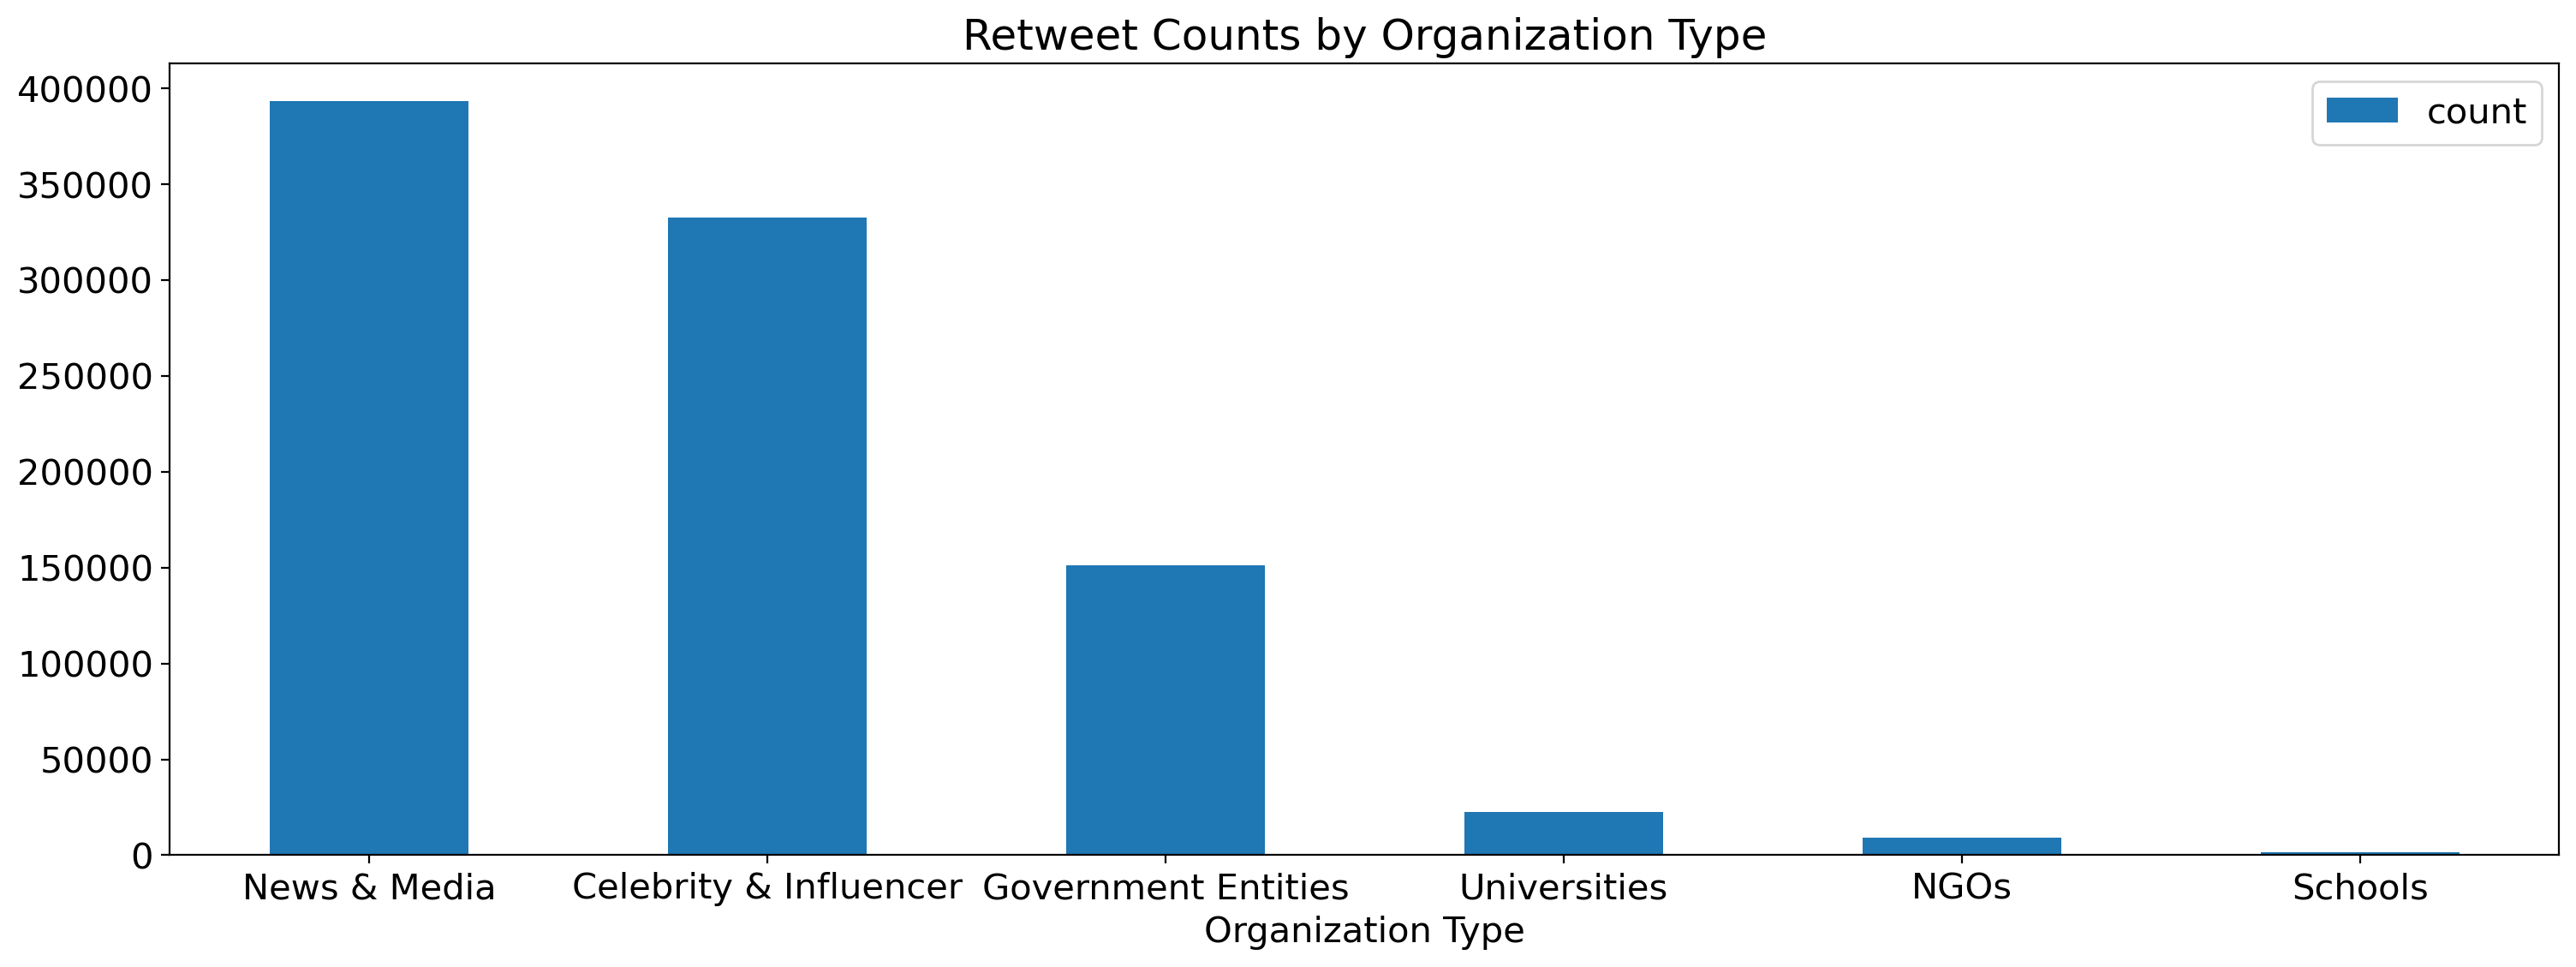

In [42]:

plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 15})

influence_rt_joined_org2.plot(kind='bar', x='organization', y='count', 
                              xlabel='Organization Type', title='Retweet Counts by Organization Type')
plt.xticks(rotation=0)
plt.show()

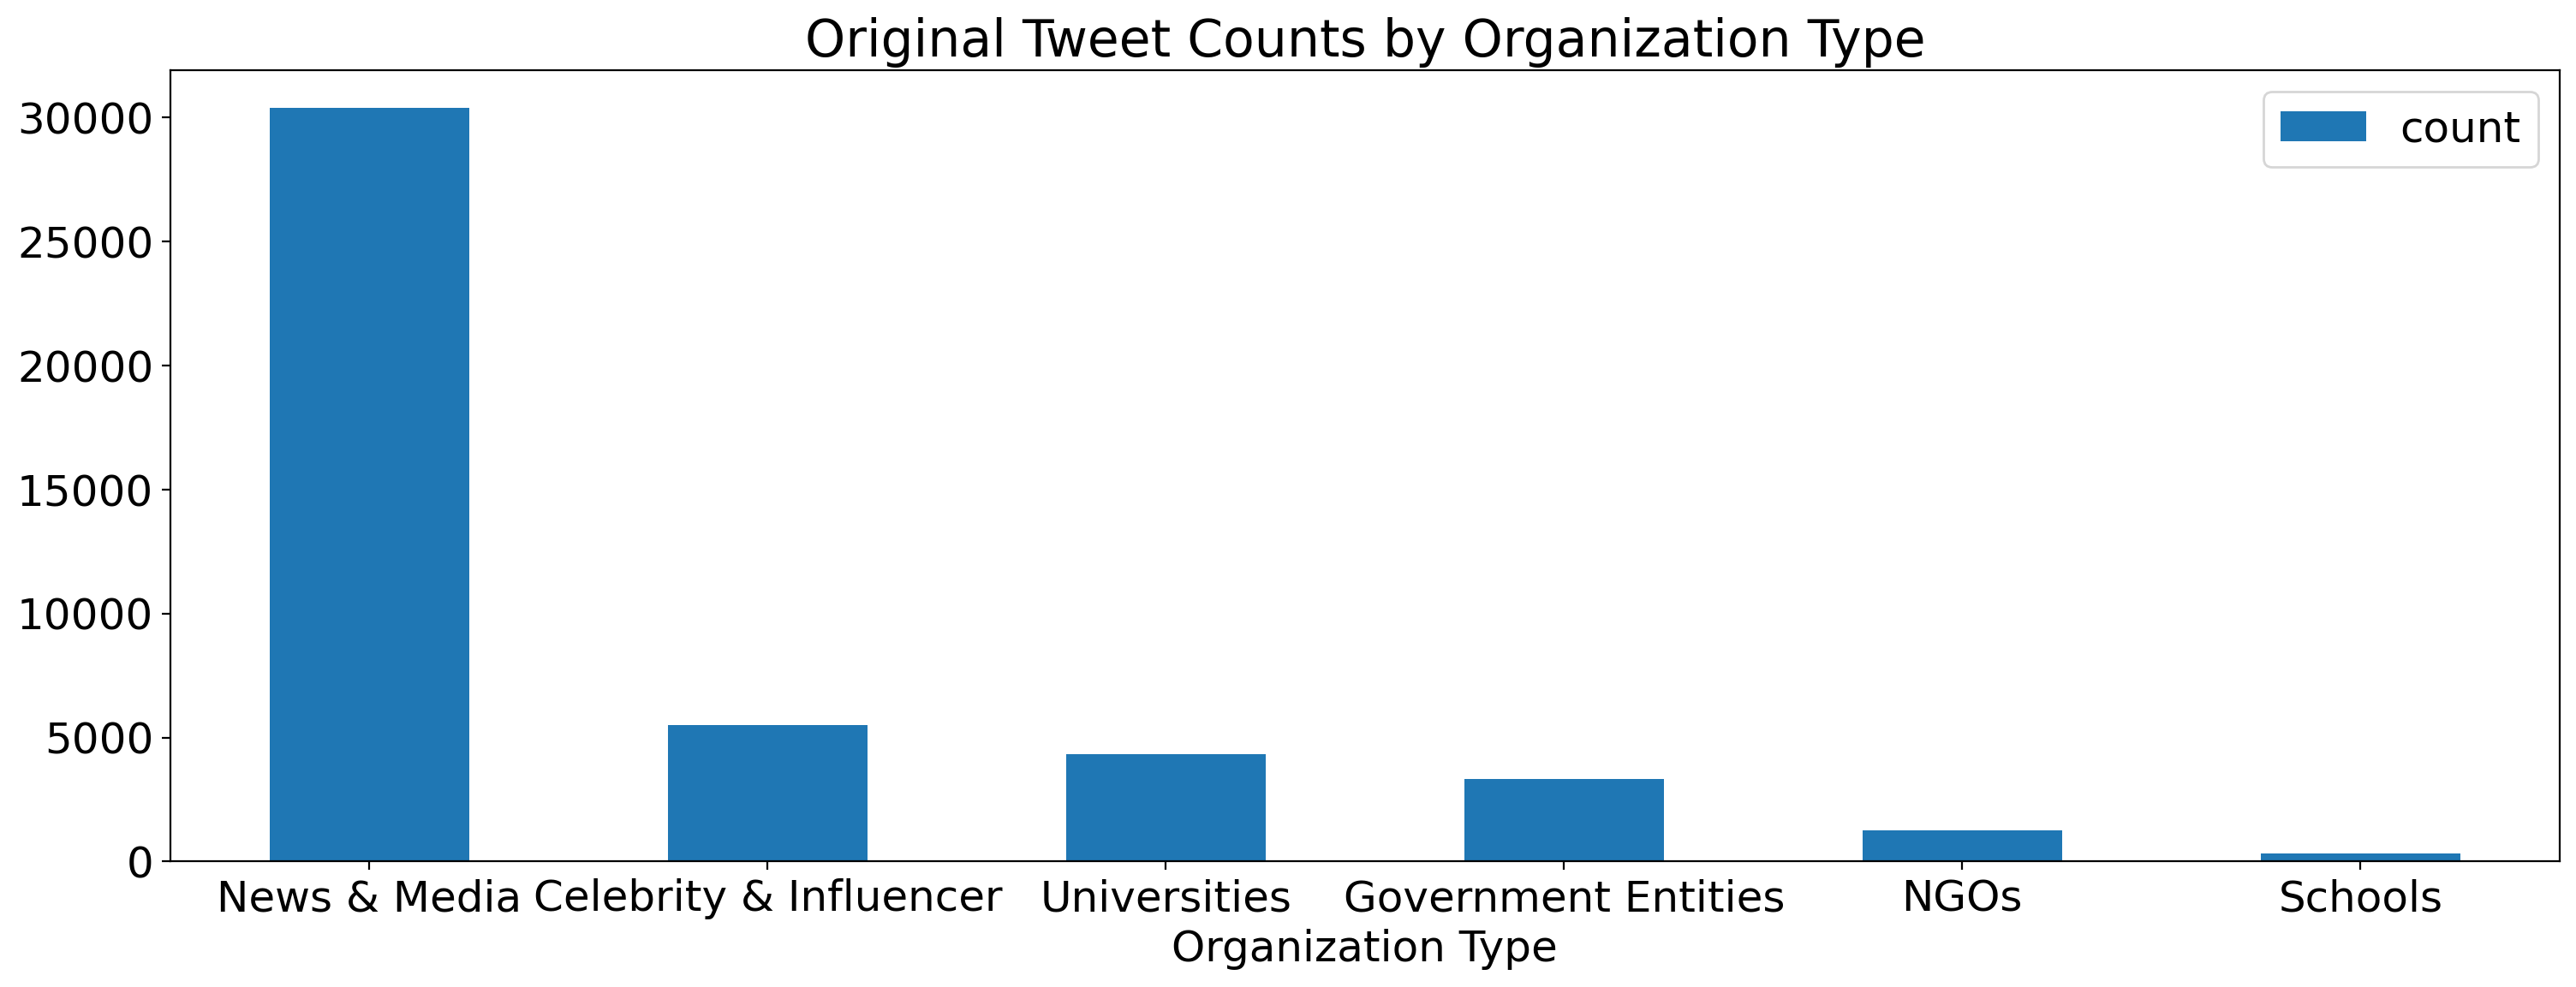

In [43]:

plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 18})

influence_original_joined_org2.plot(kind='bar', x='organization', y='count', 
                                    xlabel='Organization Type', title='Original Tweet Counts by Organization Type')
plt.xticks(rotation=0)
plt.show()

# Top Twitter by Organization

In [44]:
influence_rt_joined = influence_score_joined

In [45]:
%%time
influence_DF_ttl_joined_org = influence_rt_joined.groupBy('organization').agg(sum('total_retweeted').alias('count')).toPandas()

CPU times: user 32.9 ms, sys: 6.92 ms, total: 39.8 ms
Wall time: 8.11 s


In [46]:
influence_DF_ttl_joined_org

,organization,count
0,None,681208
1,NGOs,9257
2,Other,2888895
3,Government_Entities,150805
4,Celebrity_Influencer,325815
5,Schools,1587
6,Universities,22772
7,News_Media,393601


In [47]:
%%time
# total tweet data match
influence_DF_ttl_joined_gov = influence_rt_joined.filter(influence_rt_joined.organization == 'Government_Entities') \
                                                 .orderBy(['influence_score', 'total_retweeted'], ascending=False)

# convert to pandas
influence_ttl_gov_pd = influence_DF_ttl_joined_gov.limit(10).toPandas()

CPU times: user 52.8 ms, sys: 6.63 ms, total: 59.4 ms
Wall time: 10.2 s


In [48]:
influence_ttl_gov_pd[['user_name', 'avg_influence_coef', 'influence_score']]

,user_name,avg_influence_coef,influence_score
0,Barack Obama,0.160618,1.319861e+07
1,Narendra Modi,0.189276,8.220988e+06
2,Bernie Sanders,0.181600,1.556236e+06
3,Vice President Kamala Harris,0.209888,1.310586e+06
4,Bernie Sanders,0.137842,1.256880e+06
5,Shashi Tharoor,0.126574,8.372638e+05
6,The White House,0.269099,7.628149e+05
7,Mamata Banerjee,0.255554,6.943929e+05
8,Justin Trudeau,0.173139,6.297213e+05
9,Elizabeth Warren,0.141479,6.029885e+05


In [49]:
influence_ttl_gov_pd.influence_score.round(1).astype(str)

0    13198605.7
1     8220988.4
2     1556235.7
3     1310586.1
4     1256880.1
5      837263.8
6      762814.9
7      694392.9
8      629721.3
9      602988.5
Name: influence_score, dtype: object

In [50]:
# total tweet data match
influence_DF_ttl_joined_influencer = influence_rt_joined.filter(influence_rt_joined.organization == 'Celebrity_Influencer') \
                                                 .orderBy(['influence_score', 'total_retweeted'], ascending=False)

# convert to pandas
influence_ttl_influencer_pd = influence_DF_ttl_joined_influencer.limit(10).toPandas()

In [51]:
influence_ttl_influencer_pd[['user_name', 'avg_influence_coef', 'influence_score']] #.sort_values(by=['total_retweeted', 'influence_score'], ascending=False)

,user_name,avg_influence_coef,influence_score
0,Selena Gomez,0.151756,6.589736e+06
1,NASA,0.138052,6.487938e+06
2,ESPN,0.131338,4.108704e+06
3,NFL,0.116364,3.086122e+06
4,National Geographic,0.155115,2.782688e+06
5,Arvind Kejriwal,0.271344,2.653359e+06
6,Google,0.177435,2.579747e+06
7,Anupam Kher,0.087800,1.982505e+06
8,Kamala Harris,0.174545,1.976651e+06
9,Dwayne Johnson,0.113011,1.624680e+06


In [52]:
influence_ttl_influencer_pd.influence_score.round(1).astype(str)

0    6589736.3
1    6487937.6
2    4108704.3
3    3086122.2
4    2782688.5
5    2653358.7
6    2579747.1
7    1982505.2
8    1976650.9
9    1624680.3
Name: influence_score, dtype: object

In [53]:
# total tweet data match
influence_DF_ttl_joined_news = influence_rt_joined.filter(influence_rt_joined.organization == 'News_Media') \
                                                 .orderBy(['influence_score', 'total_retweeted'], ascending=False)

# convert to pandas
influence_ttl_influence_news_pd = influence_DF_ttl_joined_news.limit(10).toPandas()

In [54]:
influence_ttl_influence_news_pd[['user_name', 'avg_influence_coef', 'influence_score']]

,user_name,avg_influence_coef,influence_score
0,YouTube,0.104025,7.593304e+06
1,CNN,0.338508,5.986797e+06
2,The New York Times,0.372725,5.412593e+06
3,BBC Breaking News,0.204615,5.011802e+06
4,BBC News (World),0.276609,3.601439e+06
5,The Economist,0.335384,2.669741e+06
6,Reuters,0.317241,2.542329e+06
7,Fox News,0.244166,2.231647e+06
8,The Wall Street Journal,0.281451,2.010063e+06
9,TIME,0.423872,1.927266e+06


In [55]:
influence_ttl_influence_news_pd.influence_score.round(1).astype(str)

0    7593304.2
1    5986797.0
2    5412592.9
3    5011801.6
4    3601438.5
5    2669741.5
6    2542329.0
7    2231647.3
8    2010063.2
9    1927265.8
Name: influence_score, dtype: object

In [56]:
# total tweet data match
influence_DF_ttl_joined_uni = influence_rt_joined.filter(influence_rt_joined.organization == 'Universities') \
                                                 .orderBy(['influence_score', 'total_retweeted'], ascending=False)

# convert to pandas
influence_ttl_uni_pd = influence_DF_ttl_joined_uni.limit(15).toPandas()

In [57]:
influence_ttl_uni_pd[['user_name', 'avg_influence_coef', 'influence_score']]

,user_name,avg_influence_coef,influence_score
0,Jill Biden,0.144951,413454.669526
1,Recording Academy / GRAMMYs,0.154301,362313.166139
2,Rauf Klasra,0.243791,226217.821180
3,Mutahi Ngunyi,0.139543,185545.949031
4,Harvard University,0.181362,146899.544507
5,John Piper,0.209960,101774.189640
6,Stanford University,0.289336,92496.108040
7,University of Oxford,0.290862,88169.239676
8,Cambridge University,0.256268,71902.070508
9,Tennessee Football,0.170636,70531.939372


In [58]:
influence_ttl_uni_pd.influence_score.round(1).astype(str)

0     413454.7
1     362313.2
2     226217.8
3     185545.9
4     146899.5
5     101774.2
6      92496.1
7      88169.2
8      71902.1
9      70531.9
10     67118.9
11     62184.0
12     61766.9
13     57342.8
14     56244.3
Name: influence_score, dtype: object

In [59]:
# total tweet data match
influence_DF_ttl_joined_schl = influence_rt_joined.filter(influence_rt_joined.organization == 'Schools') \
                                                 .orderBy(['influence_score', 'total_retweeted'], ascending=False)

# convert to pandas
influence_ttl_schl_pd = influence_DF_ttl_joined_schl.limit(10).toPandas()

In [60]:
influence_ttl_schl_pd[['user_name', 'avg_influence_coef', 'influence_score']]

,user_name,avg_influence_coef,influence_score
0,Josh Shapiro,0.244329,19988.402952
1,Texas HS Football,0.361362,15539.601805
2,SportsDayHS,0.311492,13648.310283
3,757Teamz,0.261029,11407.579412
4,eric sondheimer,0.145286,10133.907257
5,AP for Students,0.431457,9870.866226
6,mySA high schools,0.335671,8150.318939
7,Larry Ferlazzo,0.371610,7775.617166
8,Illinois High School Association #IHSA,0.278791,6336.356545
9,FloridaHSFootball.com,0.262500,6180.545000


In [61]:
influence_ttl_schl_pd.influence_score.round(1).astype(str)

0    19988.4
1    15539.6
2    13648.3
3    11407.6
4    10133.9
5     9870.9
6     8150.3
7     7775.6
8     6336.4
9     6180.5
Name: influence_score, dtype: object

In [62]:
# total tweet data match
influence_DF_ttl_joined_celebrity = influence_rt_joined.filter(influence_rt_joined.organization == 'NGOs') \
                                                 .orderBy(['influence_score', 'total_retweeted'], ascending=False)

# convert to pandas
influence_ttl_celebrity_pd = influence_DF_ttl_joined_celebrity.limit(10).toPandas()

In [63]:
influence_ttl_celebrity_pd[['user_name', 'avg_influence_coef', 'influence_score']]

,user_name,avg_influence_coef,influence_score
0,Bill Gates,0.121059,6.059231e+06
1,Kiran Bedi,0.192436,1.225880e+06
2,ACLU,0.277852,2.004840e+05
3,NelsonMandela,0.344336,1.578169e+05
4,andyroddick,0.061933,1.476606e+05
5,edutopia,0.271666,1.251152e+05
6,Code.org,0.297217,1.030447e+05
7,Dick Vitale,0.170214,9.566718e+04
8,Bellingcat,0.094280,7.024754e+04
9,Gary Sinise,0.081667,6.900997e+04


In [64]:
influence_ttl_celebrity_pd.influence_score.round(1).astype(str)

0    6059230.9
1    1225880.2
2     200484.0
3     157816.9
4     147660.6
5     125115.2
6     103044.7
7      95667.2
8      70247.5
9      69010.0
Name: influence_score, dtype: object

# Appendix

In [65]:
#data.select(['user_id', 'id', 'retweeted', 'retweeted_status', 'retweet_count', 'quote_count'])\
#    .filter(data.retweeted != 'RT')\
    #.orderBy('retweet_count', ascending=False)\
#    .limit(10)

In [ ]:
#data.select(['user_id', 'id', 'retweeted', 'retweeted_status', 'retweet_count', 'quote_count'])\
#    .filter(data.retweeted == 'RT').limit(10)